# [Qaptiva](https://myqlm.github.io/)

## Etat de Bell (QPU: PyLinalg)

In [2]:
from qat.lang import Program, H, CNOT

Nous commencons par définir un registre de deux qubits, puis nous lui appliquons une porte de Hadamard suivi d'une CNOT.

In [3]:
qprog = Program()

nbqbits = 2

qbits = qprog.qalloc(nbqbits)

H(qbits[0])
CNOT(qbits[0], qbits[1])

Ensuite, nous exportons le programme en tant que circuit quantique, et nous allons le soumettre en tant que job à un QPU (Quantum Processing Unit)

In [4]:
circuit = qprog.to_circ()

from qat.qpus import PyLinalg

qpu = PyLinalg()
job = circuit.to_job()
result = qpu.submit(job)

Nous pouvons visualiser les résultats

In [5]:
for sample in result:
    print("State %s amplitude %s" % (sample.state, sample.amplitude))

State |00> amplitude (0.7071067811865475+0j)
State |11> amplitude (0.7071067811865475+0j)


Ainsi que la visualisation du circuit permettant cette intrication

In [6]:
circuit.display()

In [7]:
import qat.qpus
print("qat.qpus namespace:", dir(qat.qpus))

qat.qpus namespace: ['CLinalg', 'ClassicalQPU', 'PyLinalg', 'QPUHandler', 'RemoteQPU', 'SimulatedAnnealing', 'get_current_qpu']


## Max-cut (QPU: SimulatedAnnealing)

Nous allons maintenant résoudre un problème Max-cut sur un graph de 100 noeuds.
Ce graph est constitué de noeuds et d'arêtes. L'objectif du problème Max-cut est de partitionner le graph en deux sous-graph reliés par le plus grand nombres d'arêtes possible.

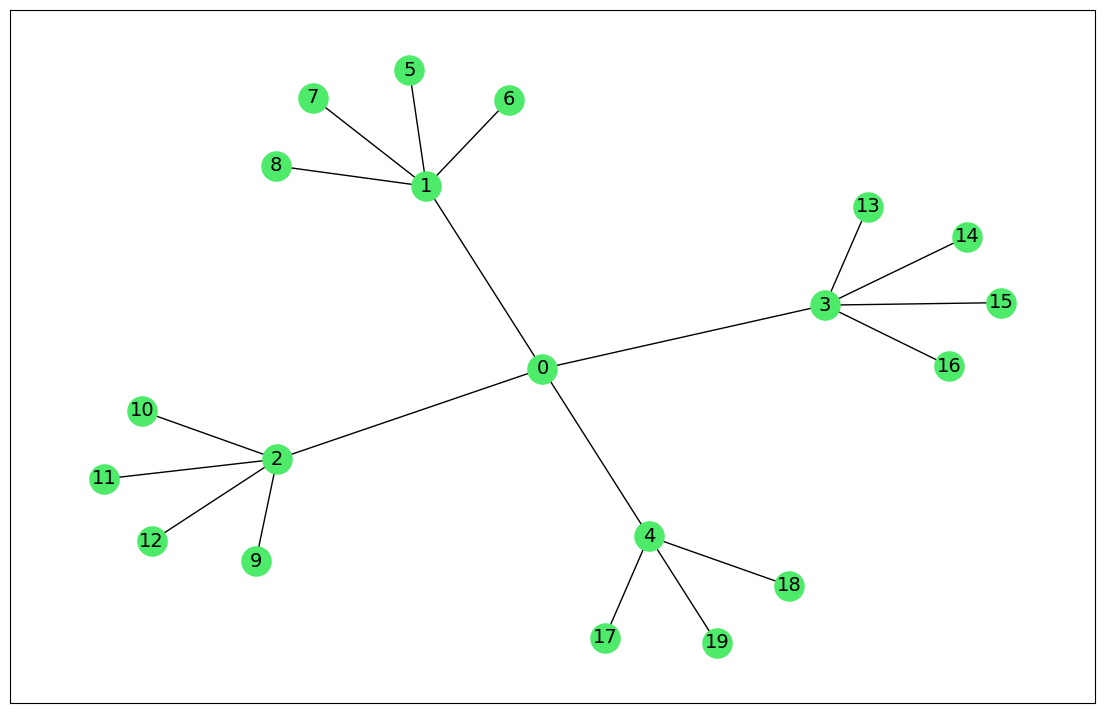

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

graph = nx.full_rary_tree(4, 20)

nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes()) * 100)
plt.figure(figsize=(14, 9))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

In [9]:
from qat.opt import MaxCut

max_cut_problem = MaxCut(graph)

The nodes in the first subgraph are [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
The nodes in the second subgraph are [1, 2, 3, 4]
The number of edges that are cut is 19.0


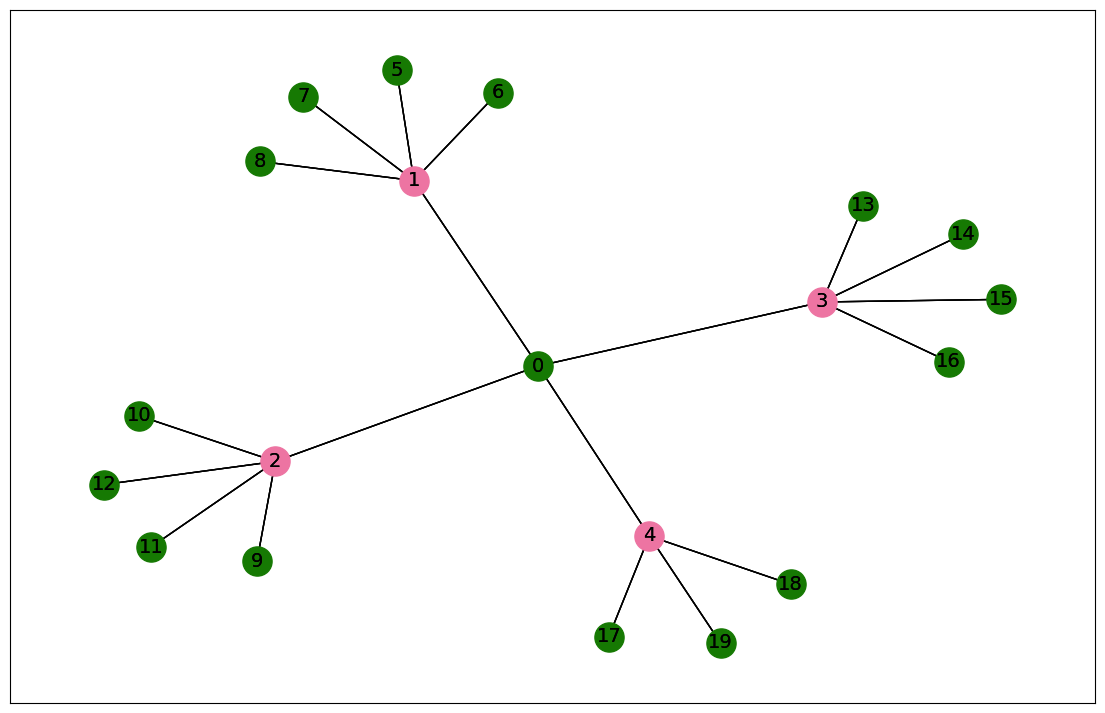

In [10]:
from qat.generators import MaxCutGenerator
from qat.qpus import SimulatedAnnealing
from qat.core import Variable

# 1. Extract parameters for SA
problem_parameters_dict = max_cut_problem.get_best_parameters()
n_steps = problem_parameters_dict["n_steps"]
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]

# 2. Create a temperature schedule and a QPU
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)

max_cut_application = MaxCutGenerator(job_type="annealing") | SimulatedAnnealing(temp_t=temp_t, n_steps=n_steps)
combinatorial_result = max_cut_application.execute(graph)

print("The nodes in the first subgraph are", combinatorial_result.subsets[0])
print("The nodes in the second subgraph are", combinatorial_result.subsets[1])
# The cost here is negative since all combinatorial optimization problems are defined as a minimization problem, so a factor of -1 is needed
print("The number of edges that are cut is", -1 * combinatorial_result.cost)

combinatorial_result.display(with_figure=True, figsize=(14, 9), node_size=440, font_size=14, pos=nodes_positions)